# Exercise 1 - M3

In this assignment, you will deepen your understanding of feature engineering, data preprocessing, and neural network modeling in PyTorch. While we suggest using a house pricing dataset for illustrative purposes, you are free to choose any dataset of interest. Your goal is to build a neural network that can handle either:

```
1. Preprocess and engineer features from your chosen dataset.
2. Build, train, and evaluate at least one neural network architecture in PyTorch:
  *   MLP if you have cross-sectional data.
  *   RNN if you have time-series/sequential data.
3. Experiment with hyperparameters (e.g., number of layers/neurons, activation functions, learning rates, epochs, etc.).
4. Evaluate and discuss your results, using appropriate performance metrics.

```


## 1. Preprocess and engineer features from your chosen dataset

I will be using recent 5 years of stock prices of NVIDIA as our dataset which will be pulled from yFinance. To train the DL model, I will be using a RNN, as the stock prices from the last 5 years are sequential data.

Let's implement the RNN using PyTorch!

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [2]:
# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('NVDA', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

In [4]:
# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [5]:
# Preview the dataframe
df

Price,Close,lag_5,rolling_mean_10,rolling_sd_10
Ticker,NVDA,,,
Date,,,,
2020-02-24,6.803477,7.214505,7.098466,0.451153
2020-02-25,6.523900,7.383297,7.096176,0.454312
2020-02-26,6.663315,7.834655,7.095578,0.454939
2020-02-27,6.292398,7.685282,7.046313,0.515011
2020-02-28,6.727586,7.321058,7.044947,0.515927
...,...,...,...,...
2025-02-03,116.660004,118.419998,131.023001,12.174614
2025-02-04,118.650002,128.990005,128.805001,12.209785


## 2. Build, train, and evaluate at least one neural network architecture in PyTorch

In [6]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

In [7]:
# Step 5: Prepare Data for RNN Input
#Creates the specific tabular data with 3 inputs and 1 labelled variable.
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5 #We choose 5 as there are no prices in weekends
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
# Step 6: Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()
# Would have been Cross Entropy, if it was a classification problem

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate set to 0.001

In [9]:
# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/20, Train Loss: 0.000153, Valid Loss: 0.017833
Epoch 4/20, Train Loss: 0.000160, Valid Loss: 0.016551
Epoch 6/20, Train Loss: 0.000160, Valid Loss: 0.015590
Epoch 8/20, Train Loss: 0.000180, Valid Loss: 0.017879
Epoch 10/20, Train Loss: 0.000264, Valid Loss: 0.016236
Epoch 12/20, Train Loss: 0.000264, Valid Loss: 0.014112
Epoch 14/20, Train Loss: 0.000207, Valid Loss: 0.011083
Epoch 16/20, Train Loss: 0.000177, Valid Loss: 0.009482
Epoch 18/20, Train Loss: 0.000150, Valid Loss: 0.008549
Epoch 20/20, Train Loss: 0.000133, Valid Loss: 0.009398


In [10]:
# Step 8: Evaluate the Model
# Evaluate on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

    # Get predictions for the training set
    train_preds = model(X_train.to(device)).cpu().numpy()
    train_actuals = y_train.numpy()

# Compute MSE for the test set
mse = mean_squared_error(test_actuals, test_preds)
print(f'Mean Squared Error on Test Set: {mse:.6f}')

# Compute MSE for the training set
train_mse = mean_squared_error(train_actuals, train_preds)
print(f'Mean Squared Error on Training Set: {train_mse:.6f}')

Mean Squared Error on Test Set: 0.178782
Mean Squared Error on Training Set: 0.002795


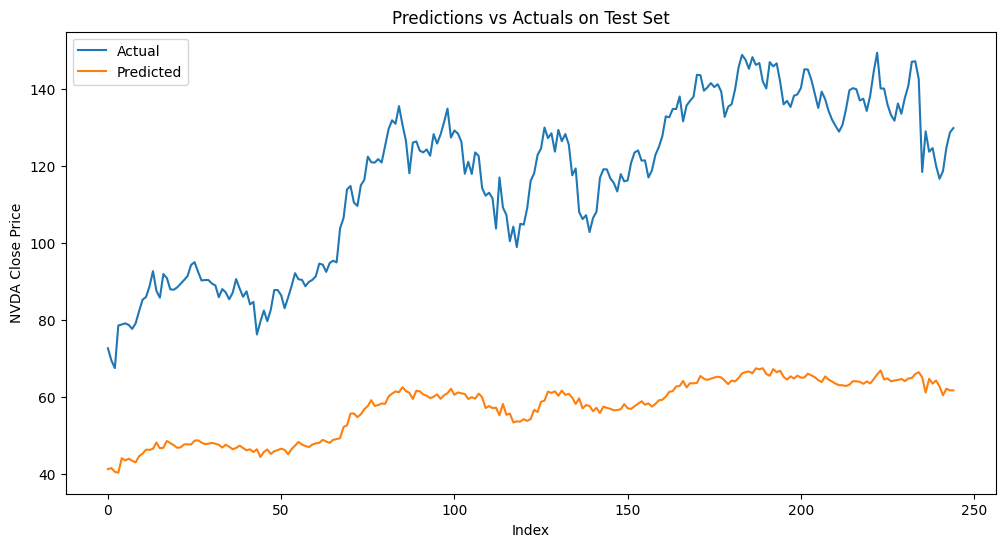

In [11]:
# Step 9: Denormalize and Visualize Predictions
# Since we have multiple features, we need to only inverse transform the target variable
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

# Denormalize the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

In [12]:
# Checking the parameters of the model
# Combine the parameters of the RNN layer and linear layer
params = list(model.parameters())

# Print the number of parameters
print("Number of parameters:", sum(p.numel() for p in params))

# Print the shapes of the parameters
for name, param in model.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    print("Weight: ", param.data)

Number of parameters: 2851
Name:  rnn.weight_ih_l0
shape:  torch.Size([50, 4])
Weight:  tensor([[-6.3046e-02,  1.1532e-02, -1.3896e-02,  1.4059e-02],
        [-3.3146e-01,  9.0607e-02, -1.6639e-01, -3.5744e-02],
        [-3.2237e-01, -5.3920e-02, -2.0730e-01, -2.5689e-02],
        [ 1.8706e-01,  2.1859e-01,  3.2979e-02,  2.3848e-02],
        [-1.8965e-01, -9.4475e-02,  2.9277e-03,  4.7281e-02],
        [ 6.5339e-01,  2.6793e-01,  4.2935e-01,  7.4660e-04],
        [-4.3520e-01, -4.6978e-02, -3.1365e-01, -5.2852e-02],
        [ 2.3821e-01,  6.2190e-02,  1.9857e-01,  1.4650e-02],
        [ 8.6772e-02,  4.1663e-02,  5.6154e-02, -2.0595e-02],
        [ 1.9390e-01,  1.2851e-01,  7.4138e-02, -2.5159e-02],
        [-7.5987e-01, -6.3687e-02, -3.8543e-01, -1.4093e-01],
        [ 3.9824e-01,  1.4751e-01,  2.2115e-01,  9.5842e-02],
        [ 1.6193e-01,  9.2677e-02,  1.6146e-01,  9.8684e-02],
        [ 2.6311e-01,  1.4878e-01,  1.9690e-01,  1.1566e-01],
        [ 7.2993e-01,  2.3648e-01,  2.4006e-

In [13]:
# Step 10: Save and Load the Model
# Save the model
torch.save(model.state_dict(), 'nvda_rnn_model.pth')

# Load the model
loaded_model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)
loaded_model.load_state_dict(torch.load('nvda_rnn_model.pth'))
loaded_model.to(device)
loaded_model.eval()

<ipython-input-13-719b5a9494a2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('nvda_rnn_model.pth'))


RNNModel(
  (rnn): RNN(4, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## 3. Experiment with hyperparameters (e.g., number of layers/neurons, activation functions, learning rates, epochs, etc.)

### Let's try decreasing the learning rate from 0.001 to 0.0005

In [14]:
# Step 1: Load and Preprocess Data for Second Model
end_date2 = pd.Timestamp.today()
start_date2 = end_date2 - pd.DateOffset(years=5)  # Last 5 years
df2 = yf.download('NVDA', start=start_date2, end=end_date2)
df2 = df2[['Close']]
df2 = df2.sort_index()

# Step 2: Create Lag and Rolling Features for Second Model
df2['lag_5'] = df2['Close'].shift(5)
df2['rolling_mean_10'] = df2['Close'].rolling(window=10).mean()
df2['rolling_sd_10'] = df2['Close'].rolling(window=10).std()
df2.dropna(inplace=True)

# Step 3: Normalize the Data for Second Model
scaler2 = MinMaxScaler()
data_scaled2 = scaler2.fit_transform(df2)

# Step 4: Split Data into Training and Testing Sets for Second Model
train_size2 = int(len(data_scaled2) * 0.8)
train_data2 = data_scaled2[:train_size2]
test_data2 = data_scaled2[train_size2:]

# Further split the training data into training and validation sets
train_valid_size2 = int(len(train_data2) * 0.8)
train_data_final2 = train_data2[:train_valid_size2]
valid_data2 = train_data2[train_valid_size2:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps2 = 5
n_features2 = data_scaled2.shape[1]
target_column_index2 = 0

# Create sequences for training, validation, and testing for Second Model
X_train2, y_train2 = create_sequences_multivariate(train_data_final2, n_timesteps2, target_column_index2)
X_valid2, y_valid2 = create_sequences_multivariate(valid_data2, n_timesteps2, target_column_index2)
X_test2, y_test2 = create_sequences_multivariate(test_data2, n_timesteps2, target_column_index2)

# Convert to tensors
X_train2 = torch.tensor(X_train2, dtype=torch.float32)
y_train2 = torch.tensor(y_train2, dtype=torch.float32)

X_valid2 = torch.tensor(X_valid2, dtype=torch.float32)
y_valid2 = torch.tensor(y_valid2, dtype=torch.float32)

X_test2 = torch.tensor(X_test2, dtype=torch.float32)
y_test2 = torch.tensor(y_test2, dtype=torch.float32)

# Create DataLoaders for Second Model
train_dataset2 = TensorDataset(X_train2, y_train2)
valid_dataset2 = TensorDataset(X_valid2, y_valid2)
test_dataset2 = TensorDataset(X_test2, y_test2)

train_loader2 = DataLoader(train_dataset2, batch_size=1, shuffle=False)
valid_loader2 = DataLoader(valid_dataset2, batch_size=1, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=1, shuffle=False)

# Step 6: Define the Second RNN Model
class RNNModel2(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel2, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model2 = RNNModel2(input_size=n_features2, hidden_size=50, output_size=1)

# Define loss function and optimizer for Second Model
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)

# Step 7: Train the Second Model
device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device2)

num_epochs2 = 20
train_losses2 = []
valid_losses2 = []

for epoch in range(num_epochs2):
    model2.train()
    train_loss2 = 0
    for inputs, targets in train_loader2:
        inputs = inputs.to(device2)
        targets = targets.to(device2)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss2 = criterion2(outputs.squeeze(), targets)
        loss2.backward()
        optimizer2.step()
        train_loss2 += loss2.item() * inputs.size(0)
    train_loss2 /= len(train_loader2.dataset)
    train_losses2.append(train_loss2)

    # Evaluate on validation set
    model2.eval()
    valid_loss2 = 0
    with torch.no_grad():
        for inputs, targets in valid_loader2:
            inputs = inputs.to(device2)
            targets = targets.to(device2)
            outputs = model2(inputs)
            loss2 = criterion2(outputs.squeeze(), targets)
            valid_loss2 += loss2.item() * inputs.size(0)
    valid_loss2 /= len(valid_loader2.dataset)
    valid_losses2.append(valid_loss2)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs2}, Train Loss: {train_loss2:.6f}, Valid Loss: {valid_loss2:.6f}')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/20, Train Loss: 0.000183, Valid Loss: 0.016820
Epoch 4/20, Train Loss: 0.000246, Valid Loss: 0.011756
Epoch 6/20, Train Loss: 0.000216, Valid Loss: 0.011888
Epoch 8/20, Train Loss: 0.000198, Valid Loss: 0.009952
Epoch 10/20, Train Loss: 0.000183, Valid Loss: 0.008235
Epoch 12/20, Train Loss: 0.000158, Valid Loss: 0.006582
Epoch 14/20, Train Loss: 0.000138, Valid Loss: 0.005181
Epoch 16/20, Train Loss: 0.000119, Valid Loss: 0.004483
Epoch 18/20, Train Loss: 0.000101, Valid Loss: 0.004132
Epoch 20/20, Train Loss: 0.000092, Valid Loss: 0.004055


In [15]:
# Step 8: Evaluate the Second Model
model2.eval()
with torch.no_grad():
    test_preds2 = model2(X_test2.to(device2)).cpu().numpy()
    test_actuals2 = y_test2.numpy()

    # Get predictions for the training set
    train_preds2 = model2(X_train2.to(device2)).cpu().numpy()
    train_actuals2 = y_train2.numpy()

# Compute MSE for the test set
mse2 = mean_squared_error(test_actuals2, test_preds2)
print(f'Mean Squared Error on Test Set: {mse2:.6f}')

# Compute MSE for the training set
train_mse2 = mean_squared_error(train_actuals2, train_preds2)
print(f'Mean Squared Error on Training Set: {train_mse2:.6f}')

Mean Squared Error on Test Set: 0.084746
Mean Squared Error on Training Set: 0.001207


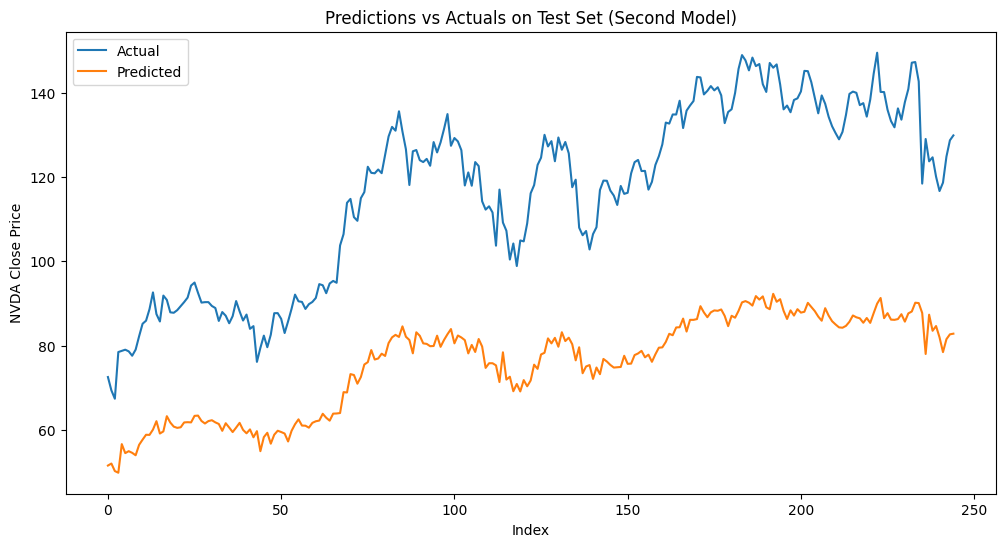

In [16]:
# Step 9: Denormalize and Visualize Predictions for Second Model
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm2 = denormalize(test_preds2, scaler2, target_column_index2)
test_actuals_denorm2 = denormalize(test_actuals2.reshape(-1, 1), scaler2, target_column_index2)

# Plot predictions vs actuals for Second Model
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm2, label='Actual')
plt.plot(test_preds_denorm2, label='Predicted')
plt.title('Predictions vs Actuals on Test Set (Second Model)')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

In [17]:
# Checking the parameters of the Second Model
params2 = list(model2.parameters())

print("Number of parameters (Second Model):", sum(p.numel() for p in params2))

for name, param in model2.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    print("Weight: ", param.data)

# Step 10: Save and Load the Second Model
torch.save(model2.state_dict(), 'nvda_rnn_model2.pth')

# Load the Second Model
loaded_model2 = RNNModel2(input_size=n_features2, hidden_size=50, output_size=1)
loaded_model2.load_state_dict(torch.load('nvda_rnn_model2.pth'))
loaded_model2.to(device2)
loaded_model2.eval()

Number of parameters (Second Model): 2851
Name:  rnn.weight_ih_l0
shape:  torch.Size([50, 4])
Weight:  tensor([[ 0.0128, -0.0238,  0.0066, -0.0386],
        [-0.0788,  0.0184, -0.1859,  0.0256],
        [ 0.4227,  0.0492,  0.1552,  0.0097],
        [-0.5341, -0.0411, -0.2396, -0.1540],
        [-0.2788, -0.0192, -0.0754, -0.0208],
        [-0.1527, -0.1256, -0.1067, -0.0493],
        [ 0.1467,  0.0147,  0.1907,  0.0060],
        [-0.3086, -0.2048, -0.1897,  0.1166],
        [-0.4219, -0.1659, -0.1307, -0.0163],
        [ 0.1700, -0.0647,  0.2219,  0.0375],
        [ 0.3311,  0.1788, -0.0135,  0.0443],
        [-0.3270, -0.1563,  0.0173,  0.0046],
        [ 0.3474, -0.0641,  0.1066,  0.0239],
        [-0.0168,  0.1021, -0.0496,  0.0172],
        [-0.3086, -0.1928, -0.1936,  0.1022],
        [ 0.5056,  0.0063,  0.2164, -0.0335],
        [ 0.5253,  0.0876,  0.1516,  0.0244],
        [ 0.2316,  0.1259,  0.1620,  0.0090],
        [-0.5684, -0.1140, -0.2679, -0.0764],
        [ 0.4131,  0.11

<ipython-input-17-99e3a4ffebba>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model2.load_state_dict(torch.load('nvda_rnn_model2.pth'))


RNNModel2(
  (rnn): RNN(4, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

### Let's try increasing the number of epochs to 100

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load and Preprocess Data for Third Model
end_date3 = pd.Timestamp.today()
start_date3 = end_date3 - pd.DateOffset(years=5)  # Last 5 years
df3 = yf.download('NVDA', start=start_date3, end=end_date3)
df3 = df3[['Close']]
df3 = df3.sort_index()

# Step 2: Create Lag and Rolling Features for Third Model
df3['lag_5'] = df3['Close'].shift(5)
df3['rolling_mean_10'] = df3['Close'].rolling(window=10).mean()
df3['rolling_sd_10'] = df3['Close'].rolling(window=10).std()
df3.dropna(inplace=True)

# Step 3: Normalize the Data for Third Model
scaler3 = MinMaxScaler()
data_scaled3 = scaler3.fit_transform(df3)

# Step 4: Split Data into Training and Testing Sets for Third Model
train_size3 = int(len(data_scaled3) * 0.8)
train_data3 = data_scaled3[:train_size3]
test_data3 = data_scaled3[train_size3:]

# Further split the training data into training and validation sets
train_valid_size3 = int(len(train_data3) * 0.8)
train_data_final3 = train_data3[:train_valid_size3]
valid_data3 = train_data3[train_valid_size3:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps3 = 5
n_features3 = data_scaled3.shape[1]
target_column_index3 = 0

# Create sequences for training, validation, and testing for Third Model
X_train3, y_train3 = create_sequences_multivariate(train_data_final3, n_timesteps3, target_column_index3)
X_valid3, y_valid3 = create_sequences_multivariate(valid_data3, n_timesteps3, target_column_index3)
X_test3, y_test3 = create_sequences_multivariate(test_data3, n_timesteps3, target_column_index3)

# Convert to tensors
X_train3 = torch.tensor(X_train3, dtype=torch.float32)
y_train3 = torch.tensor(y_train3, dtype=torch.float32)

X_valid3 = torch.tensor(X_valid3, dtype=torch.float32)
y_valid3 = torch.tensor(y_valid3, dtype=torch.float32)

X_test3 = torch.tensor(X_test3, dtype=torch.float32)
y_test3 = torch.tensor(y_test3, dtype=torch.float32)

# Create DataLoaders for Third Model
train_dataset3 = TensorDataset(X_train3, y_train3)
valid_dataset3 = TensorDataset(X_valid3, y_valid3)
test_dataset3 = TensorDataset(X_test3, y_test3)

train_loader3 = DataLoader(train_dataset3, batch_size=1, shuffle=False)
valid_loader3 = DataLoader(valid_dataset3, batch_size=1, shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=1, shuffle=False)

# Step 6: Define the Third RNN Model
class RNNModel3(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel3, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model3 = RNNModel3(input_size=n_features3, hidden_size=50, output_size=1)

# Define loss function and optimizer for Third Model
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0005)

# Step 7: Train the Third Model
device3 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device3)

num_epochs3 = 100
train_losses3 = []
valid_losses3 = []

for epoch in range(num_epochs3):
    model3.train()
    train_loss3 = 0
    for inputs, targets in train_loader3:
        inputs = inputs.to(device3)
        targets = targets.to(device3)
        optimizer3.zero_grad()
        outputs = model3(inputs)
        loss3 = criterion3(outputs.squeeze(), targets)
        loss3.backward()
        optimizer3.step()
        train_loss3 += loss3.item() * inputs.size(0)
    train_loss3 /= len(train_loader3.dataset)
    train_losses3.append(train_loss3)

    # Evaluate on validation set
    model3.eval()
    valid_loss3 = 0
    with torch.no_grad():
        for inputs, targets in valid_loader3:
            inputs = inputs.to(device3)
            targets = targets.to(device3)
            outputs = model3(inputs)
            loss3 = criterion3(outputs.squeeze(), targets)
            valid_loss3 += loss3.item() * inputs.size(0)
    valid_loss3 /= len(valid_loader3.dataset)
    valid_losses3.append(valid_loss3)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs3}, Train Loss: {train_loss3:.6f}, Valid Loss: {valid_loss3:.6f}')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Train Loss: 0.000157, Valid Loss: 0.014475
Epoch 4/100, Train Loss: 0.000176, Valid Loss: 0.014024
Epoch 6/100, Train Loss: 0.000178, Valid Loss: 0.014636
Epoch 8/100, Train Loss: 0.000176, Valid Loss: 0.013452
Epoch 10/100, Train Loss: 0.000199, Valid Loss: 0.010666
Epoch 12/100, Train Loss: 0.000222, Valid Loss: 0.009137
Epoch 14/100, Train Loss: 0.000193, Valid Loss: 0.007338
Epoch 16/100, Train Loss: 0.000151, Valid Loss: 0.005697
Epoch 18/100, Train Loss: 0.000125, Valid Loss: 0.004773
Epoch 20/100, Train Loss: 0.000108, Valid Loss: 0.004064
Epoch 22/100, Train Loss: 0.000092, Valid Loss: 0.003733
Epoch 24/100, Train Loss: 0.000087, Valid Loss: 0.003626
Epoch 26/100, Train Loss: 0.000077, Valid Loss: 0.003675
Epoch 28/100, Train Loss: 0.000078, Valid Loss: 0.003162
Epoch 30/100, Train Loss: 0.000066, Valid Loss: 0.003282
Epoch 32/100, Train Loss: 0.000071, Valid Loss: 0.002959
Epoch 34/100, Train Loss: 0.000066, Valid Loss: 0.003179
Epoch 36/100, Train Loss: 0.000060,

In [19]:
# Step 8: Evaluate the Third Model
model3.eval()
with torch.no_grad():
    test_preds3 = model3(X_test3.to(device3)).cpu().numpy()
    test_actuals3 = y_test3.numpy()

    # Get predictions for the training set
    train_preds3 = model3(X_train3.to(device3)).cpu().numpy()
    train_actuals3 = y_train3.numpy()

# Compute MSE for the test set
mse3 = mean_squared_error(test_actuals3, test_preds3)
print(f'Mean Squared Error on Test Set: {mse3:.6f}')

# Compute MSE for the training set
train_mse3 = mean_squared_error(train_actuals3, train_preds3)
print(f'Mean Squared Error on Training Set: {train_mse3:.6f}')

Mean Squared Error on Test Set: 0.053584
Mean Squared Error on Training Set: 0.000490


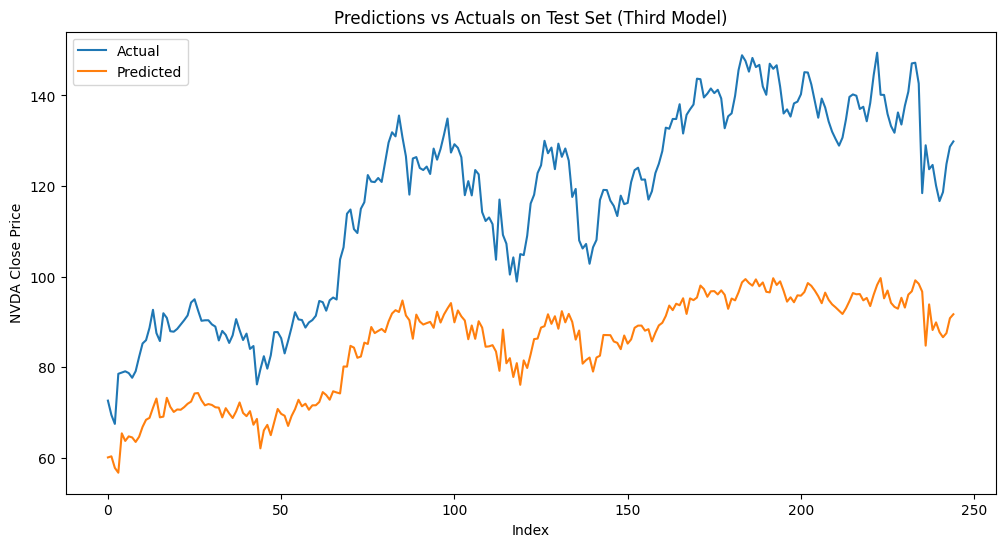

In [20]:
# Step 9: Denormalize and Visualize Predictions for Third Model
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm3 = denormalize(test_preds3, scaler3, target_column_index3)
test_actuals_denorm3 = denormalize(test_actuals3.reshape(-1, 1), scaler3, target_column_index3)

# Plot predictions vs actuals for Third Model
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm3, label='Actual')
plt.plot(test_preds_denorm3, label='Predicted')
plt.title('Predictions vs Actuals on Test Set (Third Model)')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

In [21]:
# Checking the parameters of the Third Model
params3 = list(model3.parameters())

print("Number of parameters (Third Model):", sum(p.numel() for p in params3))

for name, param in model3.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    print("Weight: ", param.data)

# Step 10: Save and Load the Third Model
torch.save(model3.state_dict(), 'nvda_rnn_model3.pth')

# Load the Third Model
loaded_model3 = RNNModel3(input_size=n_features3, hidden_size=50, output_size=1)
loaded_model3.load_state_dict(torch.load('nvda_rnn_model3.pth'))
loaded_model3.to(device3)
loaded_model3.eval()

Number of parameters (Third Model): 2851
Name:  rnn.weight_ih_l0
shape:  torch.Size([50, 4])
Weight:  tensor([[ 3.0207e-01, -1.0902e-01,  7.0942e-02,  2.9584e-02],
        [-3.2939e-01, -9.8759e-03,  2.6487e-02, -4.6682e-02],
        [-7.6425e-01, -2.3515e-02,  1.6776e-02, -3.7198e-02],
        [ 7.8537e-01, -9.0682e-02,  1.4172e-01, -1.2965e-03],
        [-2.7996e-01,  9.7096e-02, -6.8286e-02, -3.0469e-02],
        [ 5.5341e-01, -1.8575e-01,  1.4403e-01,  2.9375e-02],
        [-6.0055e-01,  1.5608e-01, -1.2731e-01, -4.3274e-02],
        [-1.4186e+00, -1.0260e-01, -3.3179e-01, -2.1920e-02],
        [-1.1364e+00, -1.2514e-01, -2.2224e-01, -5.1009e-03],
        [ 3.1793e-01, -1.3945e-01, -6.3944e-03,  5.9629e-02],
        [-7.5426e-01,  1.4762e-01, -1.5036e-02, -2.1961e-02],
        [-3.8240e-01, -1.4834e-02,  2.7811e-02, -6.5328e-02],
        [-2.2440e-02,  6.1832e-02, -1.1944e-02,  1.8754e-02],
        [-7.0088e-01,  9.6851e-02, -3.2252e-02, -9.5393e-03],
        [ 2.1926e-01, -1.5959e

<ipython-input-21-50fca7084c44>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model3.load_state_dict(torch.load('nvda_rnn_model3.pth'))


RNNModel3(
  (rnn): RNN(4, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## 4. Evaluate and discuss your results, using appropriate performance metrics

In [28]:
# MSE for the different models
print(f'Mean Squared Error on Training Set Model 1: {train_mse:.6f}')
print(f'Mean Squared Error on Test Set Model 1: {mse:.6f}')

Mean Squared Error on Training Set Model 1: 0.002795
Mean Squared Error on Test Set Model 1: 0.178782


In [29]:
print(f'Mean Squared Error on Training Set Model 2: {train_mse2:.6f}')
print(f'Mean Squared Error on Test Set Model 2 : {mse2:.6f}')

Mean Squared Error on Training Set Model 2: 0.001207
Mean Squared Error on Test Set Model 2 : 0.084746


In [30]:
print(f'Mean Squared Error on Training Set Model 3: {train_mse3:.6f}')
print(f'Mean Squared Error on Test Set Model 3: {mse3:.6f}')

Mean Squared Error on Training Set Model 3: 0.000490
Mean Squared Error on Test Set Model 3: 0.053584


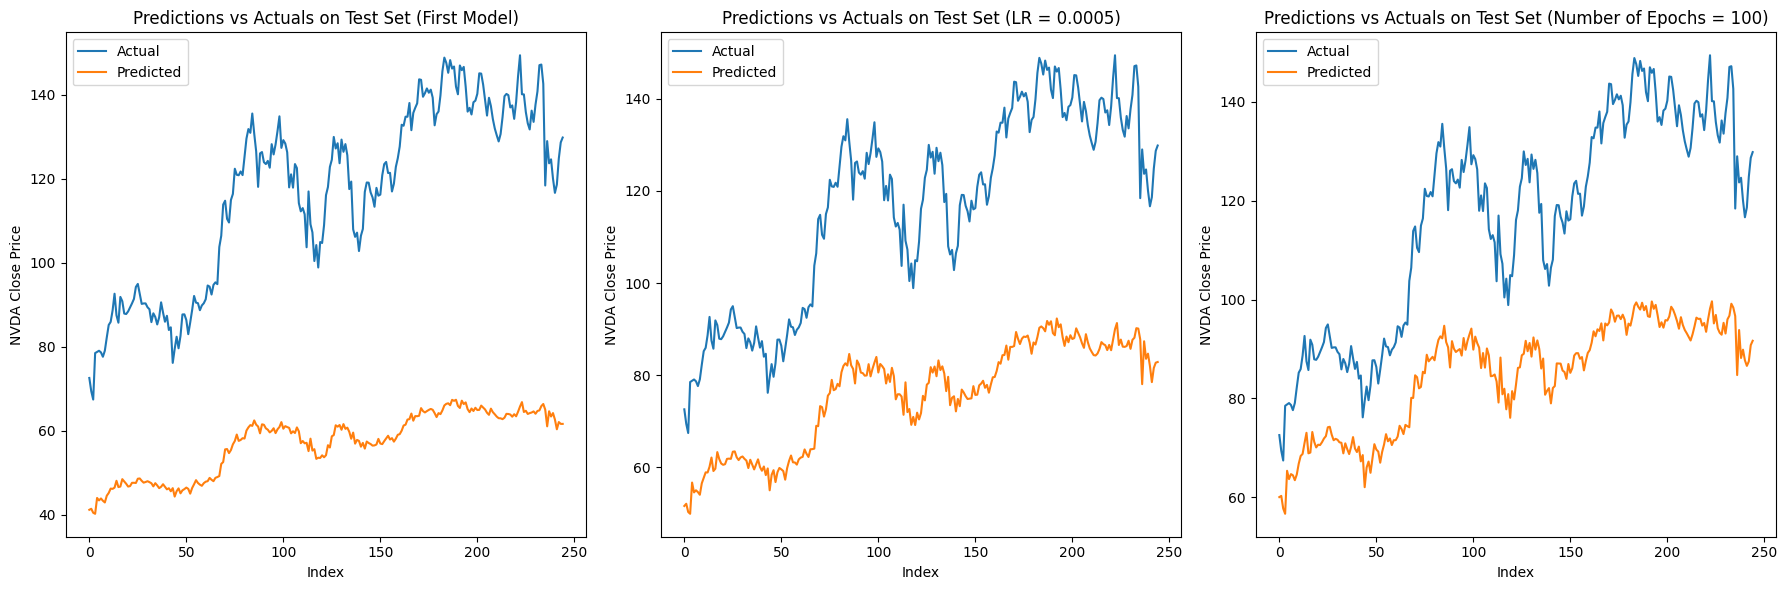

In [23]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns for side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First plot
axes[0].plot(test_actuals_denorm, label='Actual')
axes[0].plot(test_preds_denorm, label='Predicted')
axes[0].set_title('Predictions vs Actuals on Test Set (First Model)')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('NVDA Close Price')
axes[0].legend()

# Second plot
axes[1].plot(test_actuals_denorm2, label='Actual')
axes[1].plot(test_preds_denorm2, label='Predicted')
axes[1].set_title('Predictions vs Actuals on Test Set (LR = 0.0005)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('NVDA Close Price')
axes[1].legend()

# Third plot
axes[2].plot(test_actuals_denorm3, label='Actual')
axes[2].plot(test_preds_denorm3, label='Predicted')
axes[2].set_title('Predictions vs Actuals on Test Set (Number of Epochs = 100)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('NVDA Close Price')
axes[2].legend()

# Show the combined plots
plt.tight_layout()
plt.show()
